Using machine learning based methods to identify defaults in matter during laser powder processes

#### Prior python installs (Tip : Don't forget to generate a virtual environment so as not to clutter your python workspaces)

!pip install soundfile \
!pip install sounddevice\
!pip install scipy 



In [5]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.fftpack


import wave
import struct
import sys
import csv

from scipy.io import wavfile
from scipy.signal import resample

import sounddevice as sd
import soundfile as sf
data_folder = './data/'

In [72]:
file = 'A_DEFORMED1_C0'

In [73]:
df = pd.read_csv(data_folder + file + '.csv', header = None)

In [74]:
df.shape

(32000000, 1)

In [75]:

#initialisation of clock variables
clock = 3048780.48780488
delay_in_samples = 304878
g_T = 1 / clock
g_N = len(df)

print("the frequency of the signal is", clock * 1e-6, "MHz")
print("the total duration of the signal is", g_N / clock, "seconds")
print("number of samples :", len(df))


the frequency of the signal is 3.04878048780488 MHz
the total duration of the signal is 10.495999999999993 seconds
number of samples : 32000000


In [76]:
#create a second array containing the timestamps of my dataset: 
def prepareData(df,T):
    df['time'] = np.arange(len(df)) * T
    df.rename(columns = {0:'amplitude'}, inplace = True)
    return df 

conduction = prepareData(df.copy(), g_T)

In [77]:
conduction.head(5)

,amplitude,time
0,0.005493,0.000000e+00
1,0.002136,3.280000e-07
2,0.007019,6.560000e-07
3,0.005798,9.840000e-07
4,0.006104,1.312000e-06


In [78]:
#small snapshot to visualize the signal


#THERE IS A MAJOR ISSUE BECAUSE I DID NOT DEFINE TIME AS AN ORDERED INDEX. SO WHEN I EXTRACT THE SIGNAL IM ITERATING OVER 
#A SHIT TON OF VALUES (THE FULL SIZE OF THE SIGNAL) INSTEAD OF SIMPLY GOING ON THE RANGE OF THE INDEX
def extract_signal(signal, startTime, endTime):
    smaller_signal = conduction[conduction['time'].apply(lambda x: (x > startTime) & (x < endTime))]
    small_T = g_T
    small_N = len(smaller_signal)
    return smaller_signal, small_N, small_T
    

def showFFT(signal, N, T):
    amplitudes = signal['amplitude'].to_numpy()
    x = np.linspace(0.0, N*T, N, endpoint=False)
    y = amplitudes
    yf = scipy.fftpack.fft(amplitudes)
    xf = scipy.fftpack.fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()
    print("Fourier transform of the signal")
    
def plot_signal(signal):
    signal.plot(x='time', y='amplitude')  

In [79]:
sample_signal, sample_N, sample_T = extract_signal(conduction,2e-4,3e-4)


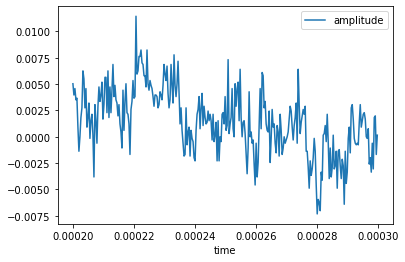

In [14]:
plot_signal(sample_signal)

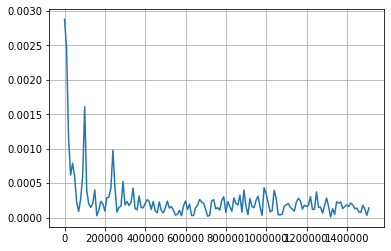

Fourier transform of the signal


In [15]:
showFFT(sample_signal, sample_N, sample_T)

In [80]:
#remove the last points so that the array length is divisible by the number of points per sample 
#in order to have equal lengths sample
point_per_sample = int(160e-3 * clock)
data = conduction['amplitude']
nb_of_samples = int(len(data)/point_per_sample)
data = data[:nb_of_samples * point_per_sample]

samples = np.array_split(data, nb_of_samples)


In [81]:


#Transforming the data into a .wav file
from scipy.io.wavfile import write
samplerate = 16000#int(clock) sample à 16khz
file = "sample_A_DEFORMED1_C0"
#convert the data into a 16 bit integer amplitude signal => change scale
max_amplitude = np.max(np.abs(conduction['amplitude']))
max_int16 = np.iinfo(np.int16).max
#data = (conduction['amplitude'] * (max_int16/max_amplitude)).astype(np.int16)

for index in range(len(samples)):
    sample = (samples[index] * (max_int16/max_amplitude)).astype(np.int16)
    write(file + str(index) + '.wav', samplerate, sample)





In [20]:
#reading the data and listening to it because why not!
#it's cool to listen to something you're just seeing as numbers!
sd.play(conduction, 1e5)
status = sd.wait()

KeyboardInterrupt: 

### Idea 1 : using an SVM to separate the data
Do PCA on the data \
Apply SVM on the data \

### Idea 2 : using a neural network to separate the data
WPT (Wavelet package transform) \
Design a CNN (Convolutional Neural Network) \



In [37]:
16*1e3 / (3*1e6)

0.005247999999999997

In [38]:
1/0.005333333333333333

190.548780487805